> * # 注意事项


# Introduction

This is a simple fork of my previous kernel (https://www.kaggle.com/taindow/pytorch-efficientnet-b0), 
except here we make use of ResNeXt and "weakly supervised pre-training" as opposed to EfficientNet. 
See https://github.com/facebookresearch/WSL-Images for model information. 
Note due to the number of parameters a single sweep of the data will take approx. 4-5h.

# Sources

Windowing functions for pre-processed data taken from the following:

- https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing 

# Parameters

In [28]:
# Input

dir_csv = '../input/rsna-intracranial-hemorrhage-detection'
dir_train_img = '../input/rsna-train-stage-1-images-png-224x/stage_1_train_png_224x'
dir_test_img = '../input/rsna-test-stage-1-images-png-224x/stage_1_test_png_224x'


In [29]:
# Parameters
n_classes = 6
n_epochs = 10
batch_size = 64


# Setup

Need to grab a couple of extra libraries

- Nvidia Apex for mixed precision training (https://github.com/NVIDIA/apex)

In [30]:
%%time
# Installing useful libraries
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

fatal: destination path 'apex' already exists and is not an empty directory.
CPU times: user 4 ms, sys: 40 ms, total: 44 ms
Wall time: 855 ms


In [31]:
!ls -l

total 17972
-rw-r--r-- 1 root root   234772 Oct 19 08:38 __notebook_source__.ipynb
drwxr-xr-x 8 root root     4096 Oct 19 08:31 apex
-rw-r--r-- 1 root root  1335277 Oct 19 08:35 test.csv
-rw-r--r-- 1 root root 16794975 Oct 19 08:35 train.csv


In [32]:
!cd /kaggle/input;ls -l

total 12
drwxr-xr-x 4 root root 4096 Sep 18 05:42 rsna-intracranial-hemorrhage-detection
drwxr-xr-x 3 root root 4096 Sep 22 10:08 rsna-test-stage-1-images-png-224x
drwxr-xr-x 3 root root 4096 Sep 22 06:36 rsna-train-stage-1-images-png-224x


In [33]:
%%time
# Libraries

from apex import amp
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
# from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, HorizontalFlip, RandomBrightnessContrast

from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from torchvision import transforms
import torchvision

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 103 µs


# CSV

In [34]:
%%time
# CSVs

train = pd.read_csv(os.path.join(dir_csv, 'stage_1_train.csv'))
train=train.sample(frac=1).reset_index(drop=True)#shuffle操作 

test = pd.read_csv(os.path.join(dir_csv, 'stage_1_sample_submission.csv'))

CPU times: user 4.28 s, sys: 232 ms, total: 4.51 s
Wall time: 4.58 s


In [35]:
%%time
# CPU times: user 31.5 s, sys: 1.12 s, total: 32.6 s
# Wall time: 32.6 s

# Split train out into row per image and save a sample

train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']
train.head()

CPU times: user 34 s, sys: 916 ms, total: 34.9 s
Wall time: 34.9 s


Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


In [36]:
%%time
undersample_seed=0
train["any"].value_counts()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 9.95 ms


0    577155
1     97103
Name: any, dtype: int64

In [37]:
%%time
num_ill_patients = train[train["any"]==1].shape[0]
num_ill_patients

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 16.6 ms


97103

In [38]:
healthy_patients = train[train["any"]==0].index.values
healthy_patients_selection = np.random.RandomState(undersample_seed).choice(
    healthy_patients, size=num_ill_patients, replace=False
)
len(healthy_patients_selection)

97103

In [39]:
sick_patients = train[train["any"]==1].index.values
selected_patients = list(set(healthy_patients_selection).union(set(sick_patients)))
len(selected_patients)/2

97103.0

In [40]:
new_train = train.loc[selected_patients].copy()
new_train["any"].value_counts()

1    97103
0    97103
Name: any, dtype: int64

In [41]:
%%time

# CPU times: user 12.6 s, sys: 1.11 s, total: 13.7 s
# Wall time: 18.5 s
# Some files didn't contain legitimate images, so we need to remove them

png = glob.glob(os.path.join(dir_train_img, '*.png'))
png = [os.path.basename(png)[:-4] for png in png]
png = np.array(png)

train = train[train['Image'].isin(png)]
train.to_csv('train.csv', index=False)

CPU times: user 11.1 s, sys: 872 ms, total: 11.9 s
Wall time: 12 s


In [42]:
%%time
# Also prepare the test data

test[['ID','Image','Diagnosis']] = test['ID'].str.split('_', expand=True)
test['Image'] = 'ID_' + test['Image']
test = test[['Image', 'Label']]
test.drop_duplicates(inplace=True)

test.to_csv('test.csv', index=False)

CPU times: user 3.2 s, sys: 32 ms, total: 3.23 s
Wall time: 3.23 s


# DataLoaders

In [43]:
%%time
# Functions

from PIL import Image

class IntracranialDataset(Dataset):

    def __init__(self, csv_file, path, labels, transform=None):
        
        self.path = path
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = labels

    def __len__(self):
        
        return len(self.data)

    def __getitem__(self, idx):
#         print("***********************")
        #idx??????
#         print("得到的數據＝",self.data)
#         print("數據類型＝",type(self.data))
#         print("idx=",idx)
#         print("self.data.loc[idx, 'Image']=",self.data.loc[idx, 'Image'])
        
        img_name = os.path.join(self.path, self.data.loc[idx, 'Image'] + '.png')
#         根据idx变量获得一个ｐｎｇ文件的完整路径+文件名

#         img_name = os.path.join(self.path, self.data[['Image']]+ '.png')
#         print("img_name=",img_name)
        img = cv2.imread(img_name)   
#         print("img=",img)
#         print("***********************")
        if self.transform:       #进行数据强化
#             print("***********************")
#             augmented = self.transform(image=img)#??????????????
            augmented=self.transform(Image.fromarray(img))
            img=augmented
#             print("**********4*************")
#             print("__getitem__得到的數據類型",type(augmented))
#             img = augmented['image']   
        
#         print("-----------------看下要返回的东西的类型和内容------------------------------------")
#         print("type(img)=",type(img))
#         print("img=",img)
#         print("type(labels)=",type(self.labels))
#         print("labels=",self.labels)
        if self.labels:#训练集的类别标签
            
            labels = torch.tensor(
                self.data.loc[idx, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']])
            return {'image': img, 'labels': labels}    
        
        else:      
            print("_------------------是走这里的吗--------------------------")
#             augmented=self.transform(Image.fromarray(img))
            augmented=Image.fromarray(img)
            img=augmented
            
            return {'image': img}#用于测试数据的读取
    
    


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 56.3 µs


In [44]:
%%time
from albumentations.pytorch import ToTensor
from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, HorizontalFlip, RandomBrightnessContrast

# Data loaders
#－－－－－－－－－－－－－－－－－－－－－下面是训练集加载－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－
transform_train = Compose([CenterCrop(200, 200), #猜测有应该是中间部分200*200的区域，这里也就是kernel标题说的CenterCrop，就是中间截取一大块
                           #Resize(224, 224),
                           HorizontalFlip(), #水平翻转用来图像强化
                           RandomBrightnessContrast(), #来自于cafｆｅ的函数，调整对比度和亮度，怎么调整似乎是不可控的
    ShiftScaleRotate(),
    ToTensor()
])
# 上面的这个东西看起来有点像是管道

train_dataset = IntracranialDataset(csv_file='train.csv', path=dir_train_img, transform=transform_train, labels=True)
#csv_file:图片数据的类别标签
#dir_train_img:图片数据
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
#－－－－－－－－－－－－－－－－－－－－－－下面是测试集加载－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－

transform_test= Compose([CenterCrop(200, 200),
                         #Resize(224, 224),
    ToTensor()
])

test_dataset = IntracranialDataset(csv_file='test.csv', path=dir_test_img, transform=transform_test, labels=False)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

CPU times: user 520 ms, sys: 12 ms, total: 532 ms
Wall time: 531 ms


In [ ]:
# type(data_loader_train)
# dir(next(iter(data_loader_train.dataset)))#會出現keys和items.
# sample=next(iter(data_loader_train.dataset))#得到的是一个dict类型
# dict_keys(['image', 'labels'])
# next(iter(data_loader_train.dataset))['labels']

# 这个ｄａｔａ_loader_train_


In [45]:
from torchvision import transforms

In [46]:
%%time
# Data loaders
#－－－－－－－－－－－－－－－－－－－－－下面是训练集加载－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(degrees = 10),
    transforms.ToTensor(),
])
# 上面的这个东西看起来有点像是管道

train_dataset = IntracranialDataset(csv_file='train.csv', path=dir_train_img, transform=transform_train, labels=True)
#csv_file:图片数据的类别标签
#dir_train_img:图片数据
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
#－－－－－－－－－－－－－－－－－－－－－－下面是测试集加载－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－－

transform_test= transforms.Compose([
#     CenterCrop(200, 200),
                         #Resize(224, 224),
    ToTensor()
])


test_dataset = IntracranialDataset(csv_file='test.csv', path=dir_test_img, transform=transform_test, labels=False)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

CPU times: user 540 ms, sys: 8 ms, total: 548 ms
Wall time: 547 ms


In [ ]:
# type(data_loader_train)
# dir(next(iter(data_loader_train.dataset)))#會出現keys和items.
# next(iter(data_loader_train.dataset))

# img_name= ../input/rsna-train-stage-1-images-png-224x/stage_1_train_png_224x/ID_000039fa0.png

In [ ]:
# dir(next(iter(data_loader_train)))

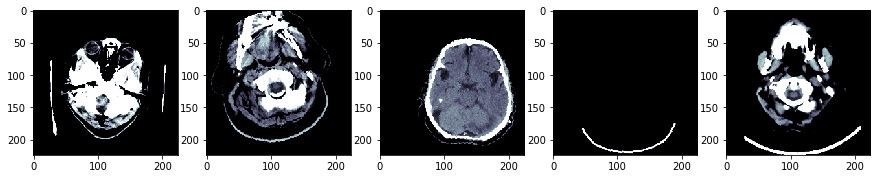

In [47]:
# 绘制一些训练图片

batch = next(iter(data_loader_train))
fig, axs = plt.subplots(1, 5, figsize=(15,5))

for i in np.arange(5):
    
    axs[i].imshow(np.transpose(batch['image'][i].numpy(), (1,2,0))[:,:,0], cmap=plt.cm.bone)


In [48]:
# 绘制一些测试图片
batch = next(iter(data_loader_test))
fig, axs = plt.subplots(1, 5, figsize=(15,5))

for i in np.arange(5):
    
    axs[i].imshow(np.transpose(batch['image'][i].numpy(), (1,2,0))[:,:,0], cmap=plt.cm.bone)


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<timed exec>", line 37, in __getitem__
  File "/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/opt/conda/lib/python3.6/site-packages/albumentations/pytorch/transforms.py", line 62, in __call__
    kwargs.update({'image': img_to_tensor(kwargs['image'], self.normalize)})
KeyError: 'image'


# Model

In [ ]:
# Model
import torchvision.models as models
model = models.vgg19(pretrained=True)
print("--------------------模型修改前-------------------------------------")

device = torch.device("cuda:0")
# model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
# print(model.eval())
# https://github.com/facebookresearch/WSL-Images
# 上面这种加载方式只支持四种模型
print("----------------------模型修改后----------------------------------")
model.classifier.fc = torch.nn.Linear(1000, n_classes)

model.to(device)

In [49]:
criterion = torch.nn.BCEWithLogitsLoss(weight=torch.Tensor([2/7,1/7,1/7,1/7,1/7,1/7]).cuda())
plist = [{'params': model.parameters(), 'lr': 2e-5}]
optimizer = optim.SGD(plist, lr=2e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=0.01,cycle_momentum=True,max_lr=0.09)

model, optimizer = amp.initialize(model, optimizer, opt_level="O1")


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


# Training（训练一次就导出权重文件）
# 为了防止kernel中途卡死，每次epoch结束后的model文件必须导出！！！

# Training－1st epoch（水平翻转概率＝1）

In [ ]:
print("------------------")

In [ ]:
!    ls

In [ ]:
# Train

# 参考下这个代码
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# 周期性学习率代码:
# https://pytorch.org/docs/stable/optim.html

model.train()    
tr_loss = 0 
tk0 = tqdm(data_loader_train, desc="Iteration")
for step, batch in enumerate(tk0):
    inputs = batch["image"]
    labels = batch["labels"]
    
    inputs = inputs.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()

    tr_loss += loss.item()

    optimizer.step()
    optimizer.zero_grad()
        
    if step > 6000:
        epoch_loss = tr_loss / 6000
        print('Training Loss: {:.4f}'.format(epoch_loss))
        break

epoch_loss = tr_loss / len(data_loader_train)
print('Training Loss: {:.4f}'.format(epoch_loss))
scheduler.step()

In [ ]:
model_name='model-1st.pkl'
torch.save(model, model_name)
# 加载整个模型 
model = torch.load(model_name)
from IPython.display import FileLink
FileLink(model_name)#导出权重文件

# Inference-1st epoch

In [ ]:
# Inference

for param in model.parameters():
    param.requires_grad = False

model.eval()

test_pred = np.zeros((len(test_dataset) * n_classes, 1))

for i, x_batch in enumerate(tqdm(data_loader_test)):
    
    x_batch = x_batch["image"]
    x_batch = x_batch.to(device, dtype=torch.float)
    
    with torch.no_grad():
        
        pred = model(x_batch)
        
        test_pred[(i * batch_size * n_classes):((i + 1) * batch_size * n_classes)] = torch.sigmoid(
            pred).detach().cpu().reshape((len(x_batch) * n_classes, 1))

# Submission-1st epoch

In [ ]:
# Submission

submission =  pd.read_csv(os.path.join(dir_csv, 'stage_1_sample_submission.csv'))
submission = pd.concat([submission.drop(columns=['Label']), pd.DataFrame(test_pred)], axis=1)
submission.columns = ['ID', 'Label']

submission.to_csv('submission.csv', index=False)
submission.head()

# Clean Up

Have to clean up since Kaggle limits the number of files that can be output from a kernel

In [ ]:
!rm -rf /kaggle/working/apex
!rm test.csv
!rm train.csv